In [1]:
pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import time
import numpy as np

In [3]:
from datasetsforecast.m4 import M4

In [4]:
group = 'Monthly'
await M4.async_download('data', group=group)

In [5]:
df, *_ = M4.load(directory='data', group=group)
n_series = len(np.unique(df.unique_id.values))

In [6]:
groups = np.random.choice(df["unique_id"].unique(), size=1000, replace=False)

In [7]:
df = df.set_index(["unique_id","ds"]).sort_index().groupby(level=0).tail(48)

df = df.loc[df.index.get_level_values('unique_id').isin(groups)].reset_index()

In [8]:
df["test"] = df["ds"]>df.groupby("unique_id")["ds"].transform(max)-3

/tmp/ipykernel_208313/2645762365.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df["test"] = df["ds"]>df.groupby("unique_id")["ds"].transform(max)-3


In [9]:
train = df[df["test"]==0].sort_values(by=["unique_id","ds"]).drop(columns="test")
test = df[df["test"]==1].sort_values(by=["unique_id","ds"]).drop(columns="test")

In [10]:
from statsforecast import StatsForecast
import time

/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from statsforecast.models import (
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA,
    AutoETS
)
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import DistributionLoss

2024-12-05 17:37:22,575	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-05 17:37:22,616	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [12]:
# Create a list of models and instantiation parameters
model_names = ["HistoricAverage","DynamicOptimizedTheta","SeasonalNaive","AutoARIMA","AutoETS","NBEATS"]

season_length = 12

models_classes_stats = [
    HistoricAverage(),
    DOT(season_length=season_length),
    SeasonalNaive(season_length=season_length),
    AutoARIMA(),
    AutoETS()
]

model_classes_neural = [
    NBEATS(h=3, input_size=10,
               stack_types = ['identity', 'trend', 'seasonality']
            )
]


INFO:lightning_fabric.utilities.seed:Seed set to 1


In [13]:
model_wrappers = []
model_wrappers = []

for model in model_classes_neural:
    model_wrappers.append(
        NeuralForecast( 
            models=[model],
            freq=1
        )
    )    
    
for model in models_classes_stats:
    model_wrappers.append(
        StatsForecast( 
            models=[model],
            freq=1, 
            fallback_model = SeasonalNaive(season_length=12),
            n_jobs=-1,
        )
    )    


In [14]:
fit_times = []

for model in model_wrappers:
    print(model)
    start = time.time()
    model.fit(df=train)
    fit_times.append(time.time()-start)
    

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
91        Non-trainable params
2.4 M     Total params
9.579     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 31:  25%|██▌       | 8/32 [00:00<00:00, 102.95it/s, v_num=14, train_loss_step=340.0, train_loss_epoch=354.0]   

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 31:  25%|██▌       | 8/32 [00:00<00:00, 101.97it/s, v_num=14, train_loss_step=340.0, train_loss_epoch=354.0]
StatsForecast(models=[HistoricAverage])
StatsForecast(models=[DynamicOptimizedTheta])
StatsForecast(models=[SeasonalNaive])
StatsForecast(models=[AutoARIMA])
StatsForecast(models=[AutoETS])


In [15]:
fit_times

[6.480893850326538,
 0.43514037132263184,
 15.151887893676758,
 0.3921022415161133,
 14.845120191574097,
 0.6846787929534912]

In [16]:
forecasts = []
forecast_times = []

for model in model_wrappers:

    start = time.time()

    if isinstance(model, NeuralForecast):
        forecasts.append(model.predict().reset_index())
    else:
        forecasts.append(model.predict(h=3))

    forecast_times.append(time.time()-start)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 32/32 [00:00<00:00, 730.52it/s]


/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [17]:
forecast_times

[0.09418129920959473,
 0.27584075927734375,
 4.57625675201416,
 0.3440537452697754,
 0.4501485824584961,
 0.3664205074310303]

In [18]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mase, rmse, rmsse
from functools import partial

metrics = [
    mape,
    rmse,
    partial(mase, seasonality=12),
    partial(rmsse, seasonality=12),
]

In [19]:
test

,unique_id,ds,y
45,M10006,85,2020.00
46,M10006,86,2040.00
47,M10006,87,2140.00
93,M10085,217,3106.70
94,M10085,218,3051.11
...,...,...,...
47950,M9878,86,1210.00
47951,M9878,87,1300.00
47997,M9956,85,2580.00
47998,M9956,86,2600.00


In [20]:
test = test.set_index("unique_id")

for forecast in forecasts:
    print(forecast)
    test = pd.concat([test,forecast.drop(columns="ds").set_index("unique_id")],axis=1)

     unique_id   ds       NBEATS
0       M10006   85  2085.551270
1       M10006   86  2053.121094
2       M10006   87  2054.608887
3       M10085  217  2739.252930
4       M10085  218  2741.322754
...        ...  ...          ...
2995     M9878   86  1275.680298
2996     M9878   87  1345.621948
2997     M9956   85  2547.271973
2998     M9956   86  2546.239990
2999     M9956   87  2551.055176

[3000 rows x 3 columns]
     unique_id   ds  HistoricAverage
0       M10006   85      3801.333333
1       M10006   86      3801.333333
2       M10006   87      3801.333333
3       M10085  217      3062.096222
4       M10085  218      3062.096222
...        ...  ...              ...
2995     M9878   86      2757.555556
2996     M9878   87      2757.555556
2997     M9956   85      3087.111111
2998     M9956   86      3087.111111
2999     M9956   87      3087.111111

[3000 rows x 3 columns]
     unique_id   ds  DynamicOptimizedTheta
0       M10006   85            2142.109863
1       M10006   86     

In [23]:
test = test.reset_index()

In [24]:
eval = evaluate(test, metrics=metrics, train_df=train)

In [25]:
metrics = eval.set_index(["unique_id","metric"]).stack().rename_axis(index={None: 'Model'}).rename("value")

In [26]:
times = pd.DataFrame(
    {
        "Model":model_names,
        "fit_time":fit_times,
        "inference_time":forecast_times
    }
).set_index("Model")

In [27]:
metrics.groupby(level=[1,2]).median().unstack()

Model,AutoARIMA,AutoETS,DynamicOptimizedTheta,HistoricAverage,NBEATS,SeasonalNaive
metric,,,,,,
mape,0.039805,0.040166,0.037180,0.095054,0.039080,0.070056
mase,0.462786,0.474370,0.457634,1.292293,0.496172,0.854438
rmse,147.335291,158.614788,145.940172,388.416634,151.055174,274.643648
rmsse,0.438268,0.448750,0.430890,1.133600,0.460690,0.774541


In [28]:
md = metrics.groupby(level=[1,2]).mean().to_frame().join(times).set_index("value",append=True).stack().rename_axis(index={None: 'time'}).rename("time_value").reset_index()

In [29]:
import seaborn as sns

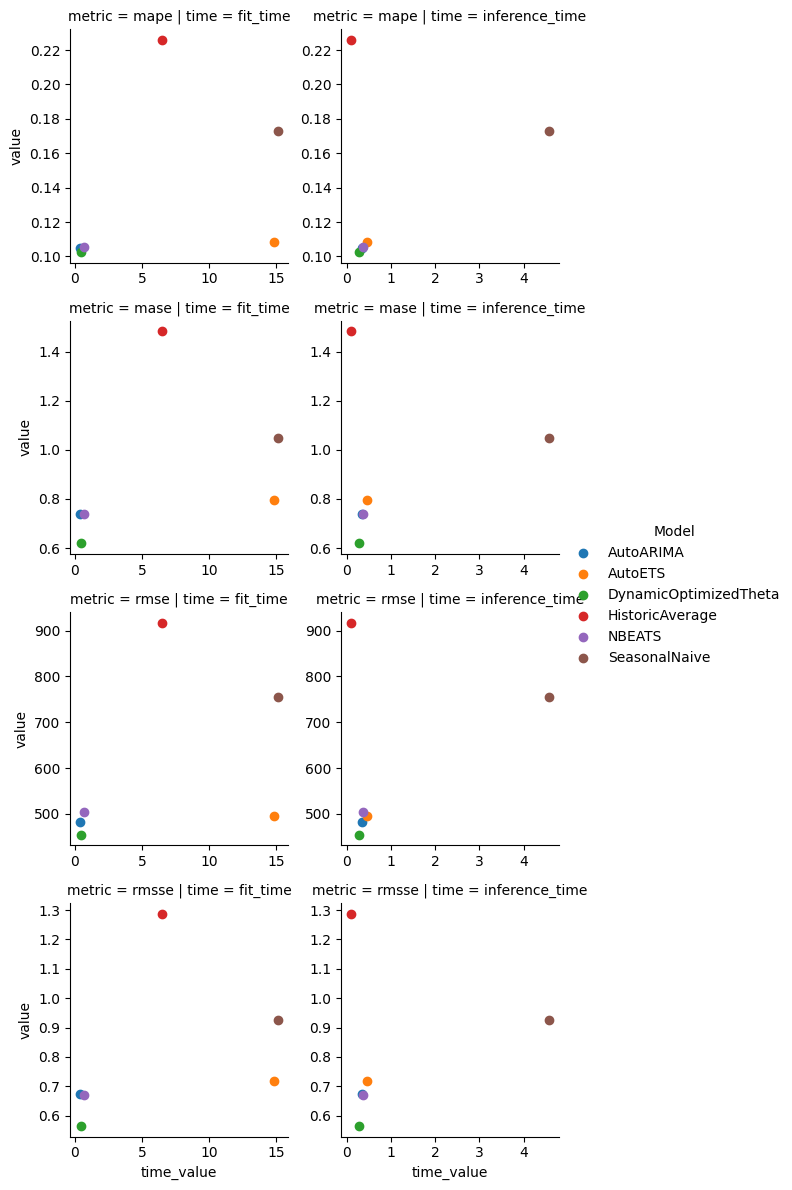

In [30]:
import matplotlib.pyplot as plt
g = sns.FacetGrid(md, row= "metric", col="time", hue = "Model",sharey=False,sharex=False)
g = g.map(plt.scatter, "time_value", "value")
g.add_legend()